### SECOND EDA OF CLIMATE CHANGE DATA

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


In [13]:
!pwd

/Users/davidcraig/code/antoninolm/climate_change_project/notebooks


In [ ]:
# 1. Load Data
# Load the dataset, treating the first row as headers
df = pd.read_csv("../raw_data/Q_13_previous-1950-2023_RR-T-Vent.csv.gz", compression="gzip", delimiter=";")

# Save the transformed dataset
# df.to_csv("Q_13_previous-1950-2023_RR-T-Vent.csv", index=False)

print("Data successfully extracted and saved with headers!")
print(df.head(10))  # Display first few rows

Data successfully extracted and saved with headers!
   NUM_POSTE      NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
0   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620701  0.0  1.0   
1   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620702  0.0  1.0   
2   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620703  0.0  1.0   
3   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620704  0.0  1.0   
4   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620705  0.0  1.0   
5   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620706  0.0  1.0   
6   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620707  0.0  1.0   
7   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620708  0.0  1.0   
8   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620709  0.0  1.0   
9   13001002  AIX-PUYRICARD  43.593333  5.413333   314  19620710  0.0  1.0   

   TN  QTN  ...  HXI2  QHXI2  FXI3S  QFXI3S  DXI3S  QDXI3S  HXI3S  QHXI3S  \
0 NaN  NaN  

In [15]:
df.shape

(1202310, 58)

In [16]:
# Convert AAAAMMJJ to datetime format
df['date'] = pd.to_datetime(df['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Set the datetime column as the index
df = df.set_index('date')

# Filter data for a specific location (change 'Location_A' to your desired location)
selected_location = "AIX-PUYRICARD"  # Change this to your desired location
df = df[df["NOM_USUEL"] == selected_location]

# Drop columns that are completely NaN (entire column is empty)
df = df.dropna(axis=1, how='all')

# Ensure dataset is sorted
df = df.sort_index()

# Ensure the datetime index has a frequency
df = df.asfreq('D')  # 'D' = Daily frequency

df

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,TX,QTX,TNTXM,QTNTXM,TAMPLI,QTAMPLI
date,,,,,,,,,,,,,,,,
1962-07-01,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,19620701.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07-02,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,19620702.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07-03,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,19620703.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07-04,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,19620704.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-07-05,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,19620705.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-11-26,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,20061126.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-27,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,20061127.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-28,13001002.0,AIX-PUYRICARD,43.593333,5.413333,314.0,20061128.0,0.7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Feature Engineering: Create lag features (previous day's temperature)
for lag in range(1, 8):  # Create 7 lag days
    df[f'temp_lag_{lag}'] = df['TNTXM'].shift(lag)

# Create time-based features
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year

# Drop rows with NaN values (due to lagging)
df = df.dropna()

# Drop specified columns
df = df.drop(columns=['NUM_POSTE', 'NUM_USUEL'], errors='ignore')

# Reorder columns: Move 'dayofyear', 'month', and 'year' to positions 3, 4, and 5
cols = list(df.columns)
cols.remove('dayofyear')
cols.remove('month')
cols.remove('year')
cols.insert(3, 'dayofyear')
cols.insert(4, 'month')
cols.insert(5, 'year')
df = df[cols]

df.shape

(8516, 25)

In [18]:
df

,NOM_USUEL,LAT,LON,dayofyear,month,year,ALTI,AAAAMMJJ,RR,QRR,...,QTNTXM,TAMPLI,QTAMPLI,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,temp_lag_6,temp_lag_7
date,,,,,,,,,,,,,,,,,,,,,
1963-01-08,AIX-PUYRICARD,43.593333,5.413333,8,1,1963,314.0,19630108.0,0.0,1.0,...,1.0,8.3,1.0,6.4,7.0,5.7,5.2,9.2,6.8,5.8
1963-01-09,AIX-PUYRICARD,43.593333,5.413333,9,1,1963,314.0,19630109.0,0.0,1.0,...,1.0,11.1,1.0,7.6,6.4,7.0,5.7,5.2,9.2,6.8
1963-01-10,AIX-PUYRICARD,43.593333,5.413333,10,1,1963,314.0,19630110.0,0.0,1.0,...,1.0,8.2,1.0,6.8,7.6,6.4,7.0,5.7,5.2,9.2
1963-01-11,AIX-PUYRICARD,43.593333,5.413333,11,1,1963,314.0,19630111.0,17.7,1.0,...,1.0,7.8,1.0,9.8,6.8,7.6,6.4,7.0,5.7,5.2
1963-01-12,AIX-PUYRICARD,43.593333,5.413333,12,1,1963,314.0,19630112.0,0.0,1.0,...,1.0,3.3,1.0,6.4,9.8,6.8,7.6,6.4,7.0,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-11-26,AIX-PUYRICARD,43.593333,5.413333,330,11,1986,314.0,19861126.0,0.0,1.0,...,1.0,13.5,1.0,9.0,8.3,9.3,9.5,7.5,10.8,10.3
1986-11-27,AIX-PUYRICARD,43.593333,5.413333,331,11,1986,314.0,19861127.0,0.0,1.0,...,1.0,9.5,1.0,7.3,9.0,8.3,9.3,9.5,7.5,10.8
1986-11-28,AIX-PUYRICARD,43.593333,5.413333,332,11,1986,314.0,19861128.0,0.0,1.0,...,1.0,13.0,1.0,7.8,7.3,9.0,8.3,9.3,9.5,7.5


<Axes: xlabel='date'>

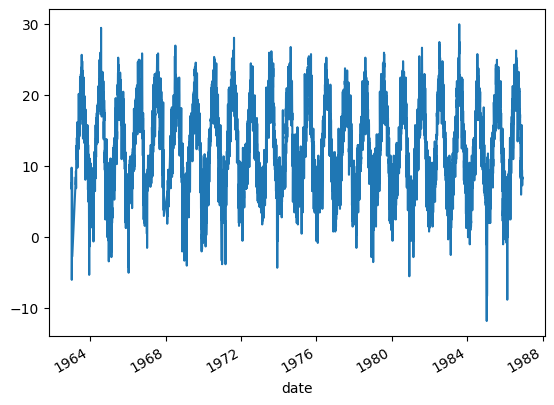

In [19]:
df["TNTXM"].plot()

In [20]:
# Days of difference should match rows of data
day_diff = (df.index.max() - df.index.min()).days
day_diff

8727

## PROBLEM WITH DATA SERIES
8727 Days betyween 1st day and last day of data but only 8516 days of data.


In [22]:
# Ensure data is sorted by date
df = df.sort_index()

# Fix: Reindex to ensure continuous dates
df = df.asfreq('D')  # Set to daily frequency
# Convert object columns to their appropriate types
df = df.infer_objects(copy=False)

# Interpolate only numeric columns
df[df.select_dtypes(include=['number']).columns] = df.select_dtypes(include=['number']).interpolate()

In [23]:
# Perform the ADF test on TNTXM (temperature column)
adf_result = adfuller(df['TNTXM'].dropna())

# Print results
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

# Interpretation
if adf_result[1] < 0.05:
    print("The data is stationary (p < 0.05), SARIMA can be used directly.")
else:
    print("The data is non-stationary (p >= 0.05), differencing may be needed before using ARIMA.")

ADF Statistic: -6.291612647632352
P-value: 3.587811367444167e-08
The data is stationary (p < 0.05), ARIMA can be used directly.


In [24]:
# Set target variable
target = 'TNTXM'  # Assign TNTXM as the target

# Columns to keep but NOT use in the model
exclude_columns = ['M_USUEL', 'LAT', 'LON', 'dayofyear', 'month', 'year', 'ALTI', 'AAAAMMJJ']

# Define features (Exclude the target variable and excluded columns)
features = [col for col in df.columns if col not in exclude_columns + [target, 'NOM_USUEL']]

# Define the train-test split ratio
train_ratio = 0.8  # 80% training, 20% testing
train_size = int(len(df) * train_ratio)

# Split dataset into training and testing sets
train = df.iloc[:train_size]  # Training data
test = df.iloc[train_size:]   # Testing data

In [ ]:
# Fit SARIMA model with baseline parameters (simple model)
sarima_model = SARIMAX(train[target],
                       order=(2, 1, 2),         # ARIMA component (p, d, q)
                       seasonal_order=(2, 1, 2, 12),  # Seasonal (P, D, Q, S)
                       enforce_stationarity=False,
                       enforce_invertibility=False,
                       simple_differencing=True)  # Faster training

# Train the model
sarima_result = sarima_model.fit(method='powell', maxiter=200, disp=True)

# Make predictions on the test set
predictions = sarima_result.predict(start=len(train), end=len(df)-1, dynamic=False)

# Evaluate baseline performance
mae = mean_absolute_error(test[target], predictions)
rmse = np.sqrt(mean_squared_error(test[target], predictions))

print(f"SARIMA Baseline Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Optimization terminated successfully.
         Current function value: 2.065809
         Iterations: 4
         Function evaluations: 383
SARIMA Baseline Model Performance:
MAE: 12.7766
RMSE: 14.3853


In [32]:
print(f"MAPE: {(mae / df[target].mean()) * 100:.2f}%")

MAPE: 102.88%


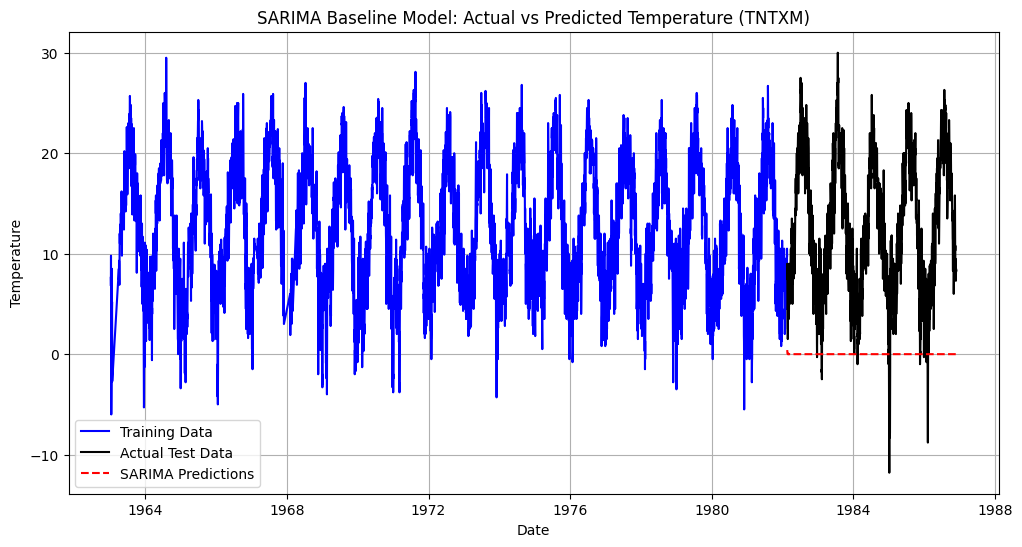

In [33]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train[target], label="Training Data", color="blue")
plt.plot(test.index, test[target], label="Actual Test Data", color="black")
plt.plot(test.index, predictions, label="SARIMA Predictions", color="red", linestyle="dashed")
plt.title("SARIMA Baseline Model: Actual vs Predicted Temperature (TNTXM)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()